In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve

import tensorflow as tf
import keras 

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D

np.random.seed(42)
tf.random.set_seed(42)

from preprocessing.getdata import *

In [34]:
df_a = get_csvdata_ADNI()
df_o= get_csvdata(drop_young=True, drop_contradictions=False)

for ID in ['013_S_1275', '099_S_0533', '123_S_0050', '131_S_0457', '137_S_0796']:
    df_a = df_a[df_a['ID']!=ID]

df_a = df_a[df_a['Group']!='MCI']
y_a = (df_a['Group']!='CN').astype(int)
df_a_train, df_a_test, y_a_train, y_a_test = train_test_split(df_a['ID'], y_a, stratify=y_a, random_state=42)

y_o = df_o['CDR']
df_o_train, df_o_test, y_o_train, y_o_test = train_test_split(df_o['ID'], y_o, stratify=y_o, random_state=42)

y_test = np.concatenate((y_o_test, y_a_test))

In [27]:
N = 5
d = 1
mdict = {0: 95, 1: 110, 2: 90}

def get_test(dim, N, d):
    m = mdict[dim]
    X_test_o = get_slices(df_o_test, dim=dim, m=m, N=N, d=d)
    X_test_a = get_slices_ADNI2(df_a_test, dim=dim, m=m, N=N, d=d)

    X_test = np.concatenate((X_test_o, X_test_a), axis=0)

    X_test = np.repeat(X_test[..., np.newaxis], 3, -1)
    return X_test

X_test0 = get_test(0, N, d)
X_test1 = get_test(1, N, d)
X_test2 = get_test(2, N, d)

In [19]:
model0 = tf.keras.models.load_model('../models/axis0')
model1 = tf.keras.models.load_model('../models/axis1')
model2 = tf.keras.models.load_model('../models/axis2')

In [28]:
y_prob0 = model0.predict(X_test0)
y_prob1 = model1.predict(X_test1)
y_prob2 = model2.predict(X_test2)

In [29]:
y_prob0 = y_prob0.reshape(len(df_o_test)+len(df_a_test),1+2*N)
y_prob1 = y_prob1.reshape(len(df_o_test)+len(df_a_test),1+2*N)
y_prob2 = y_prob2.reshape(len(df_o_test)+len(df_a_test),1+2*N)

In [30]:
y_prob0 = np.mean(y_prob0, axis=1)
y_prob1 = np.mean(y_prob1, axis=1)
y_prob2 = np.mean(y_prob2, axis=1)

In [32]:
y_test.shape

(1716,)

In [35]:
print('accuracy of axis 0: ', accuracy_score(y_test, y_prob0.round()))
print('accuracy of axis 1: ', accuracy_score(y_test, y_prob1.round()))
print('accuracy of axis 2: ', accuracy_score(y_test, y_prob2.round()))

accuracy of axis 0:  0.6538461538461539
accuracy of axis 1:  0.75
accuracy of axis 2:  0.6923076923076923


In [36]:
y_prob = np.stack((y_prob0, y_prob1, y_prob2)).T

In [37]:
y_pred = np.mean(y_prob, axis=1).round()

accuracy:  0.71
recall:  0.74
precision:  0.67


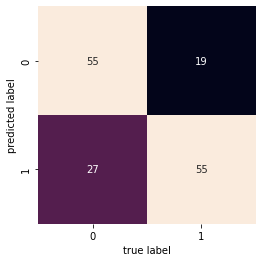

In [38]:
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred.round()).round(2))
print('recall: ' , recall_score(y_test, y_pred.round()).round(2))
print('precision: ' , precision_score(y_test, y_pred.round()).round(2))

In [39]:
list(range(80,120,5))

[80, 85, 90, 95, 100, 105, 110, 115]